### SciPy Hierarchical Clustering and Dendrograms

Jay Urbain, PhD

Credits:  
Jörn's Blog, https://joernhees.de/blog   
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
    
    
Objectives:  
- use scipy's hierarchical clustering
- plot a dendrogram scipy hierarchical clustering
- use the dendrogram to select a distance cut-off (aka determining the number of clusters k in your data)
- retrieve the k clusters
- visualize clusters (2D case)

In [1]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [2]:
# some setting for this notebook to actually show the graphs inline
# you probably won't need this
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

#### Generating Sample Data

(150, 2)


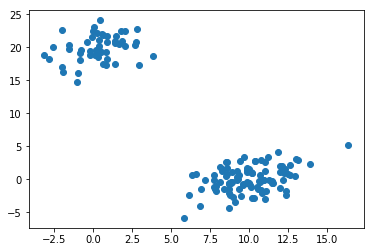

In [4]:
# generate two clusters: a with 100 points, b with 50:
np.random.seed(4711)  # for repeatability of this tutorial
a = np.random.multivariate_normal([10, 0], [[3, 1], [1, 4]], size=[100,])
b = np.random.multivariate_normal([0, 20], [[3, 1], [1, 4]], size=[50,])
X = np.concatenate((a, b),)
print (X.shape)  # 150 samples with 2 dimensions
plt.scatter(X[:,0], X[:,1])
plt.show()

#### Perform the Hierarchical Clustering

As the [scipy linkage docs tell us](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html), there are several different methods for linkage when using heirarchical aglomerative clustering.

`ward` is one of the methods that can be used to calculate the distance between newly formed clusters. `ward` causes linkage() to use the Ward variance minimization algorithm.

It's a good default choice, but there are other common linkage methods like 'single', 'complete', 'average', ... and the different distance metrics like 'euclidean' (default), 'cityblock' aka Manhattan, 'hamming', 'cosine', etc. 

The best options are typically identifed through experimentation, especially if you feel that your data should not just be clustered to minimize the overall intra cluster variance in euclidean space. For example, when working with long (binary) feature vectors (e.g., word-vectors in text clustering).

Ward's linkage with scipy:

In [6]:
# generate the linkage matrix
Z = linkage(X, 'ward')

A useful metric is the [Cophenetic Correlation Coefficient](https://en.wikipedia.org/wiki/Cophenetic_correlation). You can apply it to your clustering with help of the cophenet() function. This basically compares (correlates) the actual pairwise distances of all your samples to those implied by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances, which in our case is pretty close:

In [7]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.9800148387574268

No matter what method and metric you pick, the linkage() function will use that method and metric to calculate the distances of the clusters (starting with your n individual samples (aka data points) as singleton clusters)) and in each iteration will merge the two clusters which have the smallest distance according the selected method and metric. It will return an array of length n - 1 giving you information about the n - 1 cluster merges which it needs to pairwise merge n clusters. 

$Z_i$ will tell us which clusters were merged in the $i^{th}$ iteration, let's take a look at the first two points that were merged:

In [8]:
Z[0]

array([52.     , 53.     ,  0.04151,  2.     ])

We can see that each row of the resulting array has the format [idx1, idx2, dist, sample_count].

In its first iteration the linkage algorithm decided to merge the two clusters with indices 52 and 53, as they only had a distance of 0.04151. This created a cluster with a total of 2 samples.

In [9]:
Z[1]

array([14.     , 79.     ,  0.05914,  2.     ])

In the second iteration the algorithm decided to merge the clusters with indices 14 and 79, which had a distance of 0.05914. This again formed another cluster with a total of 2 samples.

The indices of the clusters until now correspond to our samples. Remember that we had a total of 150 samples, so indices 0 to 149. Let's have a look at the first 20 iterations:

In [11]:
Z[:20]

array([[ 52.     ,  53.     ,   0.04151,   2.     ],
       [ 14.     ,  79.     ,   0.05914,   2.     ],
       [ 33.     ,  68.     ,   0.07107,   2.     ],
       [ 17.     ,  73.     ,   0.07137,   2.     ],
       [  1.     ,   8.     ,   0.07543,   2.     ],
       [ 85.     ,  95.     ,   0.10928,   2.     ],
       [108.     , 131.     ,   0.11007,   2.     ],
       [  9.     ,  66.     ,   0.11302,   2.     ],
       [ 15.     ,  69.     ,   0.11429,   2.     ],
       [ 63.     ,  98.     ,   0.1212 ,   2.     ],
       [107.     , 115.     ,   0.12167,   2.     ],
       [ 65.     ,  74.     ,   0.1249 ,   2.     ],
       [ 58.     ,  61.     ,   0.14028,   2.     ],
       [ 62.     , 152.     ,   0.1726 ,   3.     ],
       [ 41.     , 158.     ,   0.1779 ,   3.     ],
       [ 10.     ,  83.     ,   0.18635,   2.     ],
       [114.     , 139.     ,   0.20419,   2.     ],
       [ 39.     ,  88.     ,   0.20628,   2.     ],
       [ 70.     ,  96.     ,   0.21931,   2. 

We can observe that until iteration 13 the algorithm only directly merged original samples. We can also observe the monotonic increase of the distance.

In iteration 13 the algorithm decided to merge cluster indices 62 with 152. If you paid attention the 152 should astonish you as we only have original sample indices 0 to 149 for our 150 samples. All indices idx >= len(X) actually refer to the cluster formed in $Z[idx - len(X)]$.

This means that while idx 149 corresponds to $X[149]$ that idx 150 corresponds to the cluster formed in Z[0], idx 151 to $Z[1], 152 to Z[2], ...$

Hence, the merge iteration 13 merged sample 62 to our samples 33 and 68 that were previously merged in iteration 2 (152 - 2).

Let's check out the points coordinates to see if this makes sense:

In [12]:
X[[33, 68, 62]]

array([[ 9.83913, -0.4873 ],
       [ 9.89349, -0.44152],
       [ 9.97793, -0.56383]])

We can plot the data again and highlight these points.

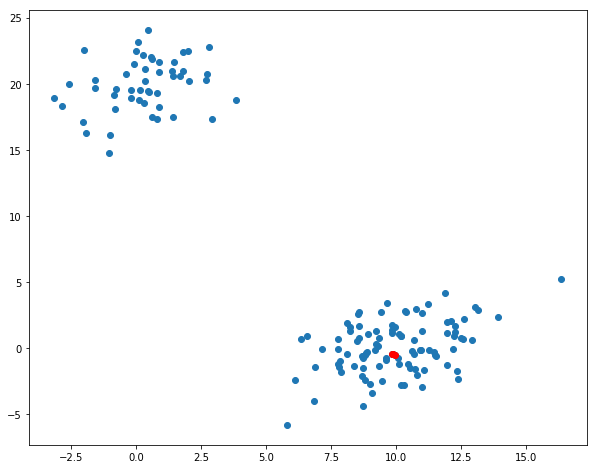

In [14]:
idxs = [33, 68, 62]
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])  # plot all points
plt.scatter(X[idxs,0], X[idxs,1], c='r')  # plot interesting points in red again
plt.show()

We can see that the 3 red dots are very close together.

The same happended in interation 14.

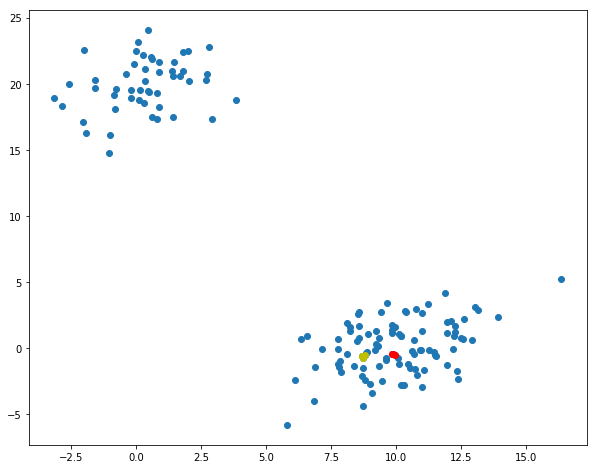

In [15]:
idxs = [33, 68, 62]
plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1])
plt.scatter(X[idxs,0], X[idxs,1], c='r')
idxs = [15, 69, 41]
plt.scatter(X[idxs,0], X[idxs,1], c='y')
plt.show()

#### Plotting a dendogram

On the x axis you see labels. If you don't specify anything else they are the indices of your samples in X.
On the y axis you see the distances (of the 'ward' method in our case).

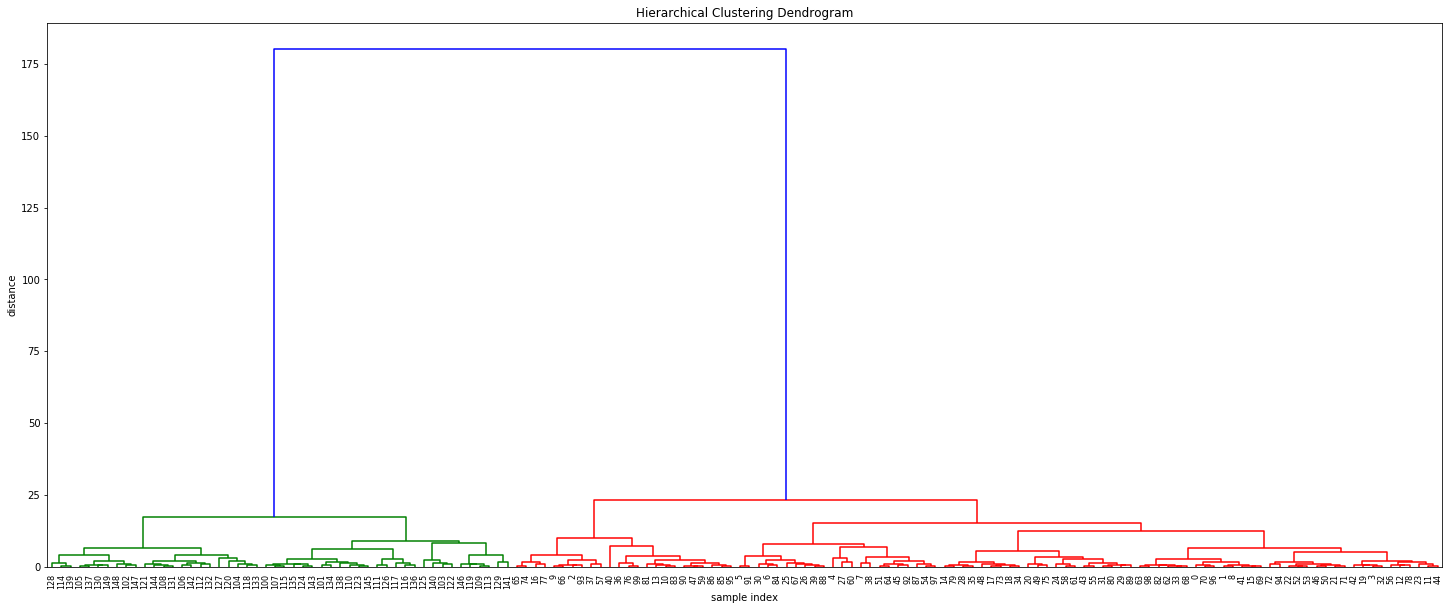

In [16]:
# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

#### Summarizing:

- horizontal lines are cluster merges 
- vertical lines tell you which clusters/labels were part of merge forming that new cluster  
- heights of the horizontal lines tell you about the distance that needed to be "bridged" to form the new cluster  

You can also see that from distances > 25 up there's a huge jump of the distance to the final merge at a distance of approx. 180. Let's have a look at the distances of the last 4 merges:
    
    

In [17]:
Z[-4:,2]

array([ 15.11533,  17.11527,  23.12199, 180.27043])